In [128]:
!pip install ucimlrepo
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from ucimlrepo import fetch_ucirepo

dataf = fetch_ucirepo(id=15)
X = dataf.data.features
y = dataf.data.targets

Look for missing data and quick look at data:

# 1) Data Preproccessing
----

In [69]:
X.head()

,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses
0,5,1,1,1,2,1.0,3,1,1
1,5,4,4,5,7,10.0,3,2,1
2,3,1,1,1,2,2.0,3,1,1
3,6,8,8,1,3,4.0,3,7,1
4,4,1,1,3,2,1.0,3,1,1


In [70]:
X.shape

(699, 9)

array([[<Axes: title={'center': 'Clump_thickness'}>,
        <Axes: title={'center': 'Uniformity_of_cell_size'}>,
        <Axes: title={'center': 'Uniformity_of_cell_shape'}>],
       [<Axes: title={'center': 'Marginal_adhesion'}>,
        <Axes: title={'center': 'Single_epithelial_cell_size'}>,
        <Axes: title={'center': 'Bare_nuclei'}>],
       [<Axes: title={'center': 'Bland_chromatin'}>,
        <Axes: title={'center': 'Normal_nucleoli'}>,
        <Axes: title={'center': 'Mitoses'}>]], dtype=object)

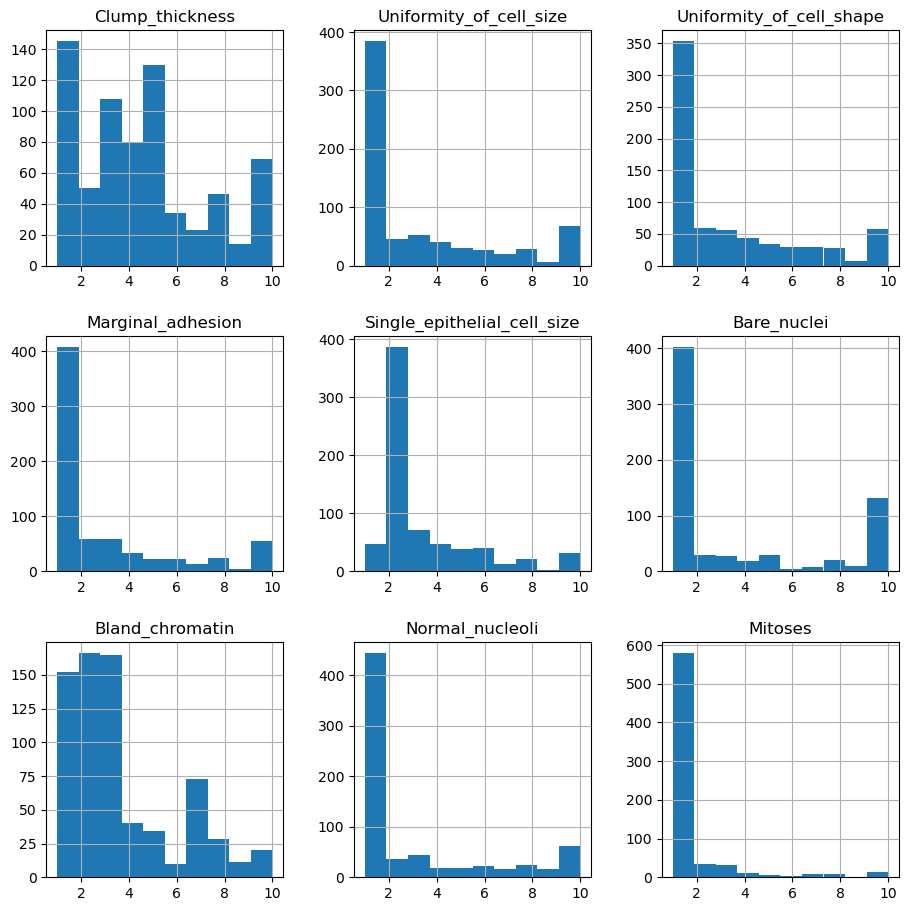

In [71]:
X.iloc[:,:9].hist(figsize=(11,11))

array([[<Axes: title={'center': 'Class'}>]], dtype=object)

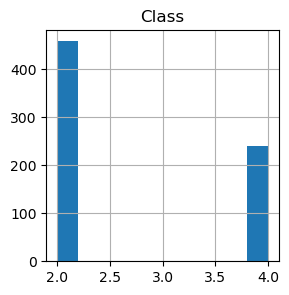

In [72]:
y.iloc[:,:2].hist(figsize=(3,3))

**1.1 Missing Values Imputation**

In [92]:
X.isnull().sum()

Clump_thickness                 0
Uniformity_of_cell_size         0
Uniformity_of_cell_shape        0
Marginal_adhesion               0
Single_epithelial_cell_size     0
Bare_nuclei                    16
Bland_chromatin                 0
Normal_nucleoli                 0
Mitoses                         0
dtype: int64

In [93]:
y.isnull().sum()

Class    0
dtype: int64

Imputation using mode

In [94]:
mode_imputer = SimpleImputer(strategy='most_frequent')
X_imputed = mode_imputer.fit_transform(X)

Check that they have all been filled in

In [95]:
nan_count = np.isnan(X_imputed).sum()
print(nan_count)

0


In [96]:
X_imputed.shape

(699, 9)

# 2 Princial Component Analysis
----

**2.1 Standardisation Prior to PCA**

The decision to standardise the data before doing PCA is determined by the measurement scales of the original features. Because PCA produces a feature subspace that maximises variation along the axes, standardising the data makes sense, especially if the features were measured on different scales. Despite the fact that all variables in the breast cancer dataset were assessed on the same scale (1-10), each item reflects a separate element of cell properties and may have different distributions and variances. We therefore apply standard normalisation to guarantee that all features contribute equally to the PCA. This seeks to rescale the features to reflect the parameters of a standard normal distribution with a mean of zero and a standard deviation of one. This is important since PCA operates on the assumption that the data is normally distributed and is highly sensitive to the variance of the features. If we do not normalise the data, features with wide range differences will outweigh those with modest ranges, potentially leading to misleading results [1].

In [129]:
#Remove this later
import pandas as pd

# Assuming X is your DataFrame
X = X.fillna(X.mean())

In [130]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [131]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**2.2 The Process of PCA**

The process of Principal Component Analysis (PCA) can be summarised through four main steps. Initially, we compute the **mean vector**, which in our case is 9-dimensional, representing each of the individual raw features in our dataset. The mean vector $\boldsymbol{\vec{x}}$ is calculated using the formula:

\begin{equation}
\boldsymbol{\vec{x}} = \frac{1}{N} \sum_{i=1}^{N} \boldsymbol{\vec{x}}^{(i)}
\end{equation}

Here, $N$ represents the number of observations, and $\boldsymbol{\vec{x}}^{(i)}$ signifies each datum.

The purpose of this step is to centralise the data by subtracting the mean vector from each data point. This subtraction corresponds to an overall translation in the space where the data lives and carries no information about the actual relationships between the variables [2]. Note that in our situation, this phase will not result in any data shift because we had standardised the data in the previous stage to have a mean of 0 and variance of 1, but we still include it because it is part of the PCA process and may be useful if we decide not to standardise the data.

<div style="text-align: center;">
<img src="Figures/Standard normalisation.jpg" alt="Alternative text" width="700" height="250" />
</div>

Next step is then to calculate the **covariance matrix** of the whole dataset which is given by:

\begin{equation} 
\mathbf{\Sigma} = \frac{1}{N-1} \sum_{i=1}^{N} (\boldsymbol{\vec{x}}^{(i)} - \boldsymbol{\bar{x}})^T \cdot (\boldsymbol{\vec{x}}^{(i)} - \boldsymbol{\bar{x}})
\end{equation}


Note that in our convention $\boldsymbol{\vec{x}}^{(i)}$ and $\boldsymbol{\bar{x}}$ are row vectors. The equation above is therefore the sum of the dot products of 9D column vectors and 9D row vectors. This makes $\mathbf{\Sigma}$ a 9 × 9 square matrix.

Then, using the **scipy.linalg.eigh** function, we calculate the eigenvalues and eigenvectors of $\mathbf{\Sigma}$, that is we wish to compute the unit vectors $\boldsymbol{\vec{v}}$ that obey:

\begin{equation}
\mathbf{\Sigma} \boldsymbol{\vec{v}} = \lambda \boldsymbol{\vec{v}}
\end{equation}

where $\lambda$ represents the eigenvalue corresponding to the eigenvector $\boldsymbol{\vec{v}}$. The eigenvalues are derived from the matrix's characteristic polynomial, which is expressed as:

\begin{equation}
\text{det}(\mathbf{\Sigma} - \lambda \mathbf{I}) = 0
\end{equation}

By substituting each eigenvalue $\lambda$ into the equation and solving for $\boldsymbol{\vec{v}}$, one may then obtain the corresponding eigenvector for each eigenvalue. With nine raw features in our dataset, we expect to extract nine related eigenpairs. The eigenvectors calculated are the components. To choose the first principal component we simply look for the eigenpair with the largest eigenvalue. If we do this iteratively and sort the eigenpairs by eigenvalues, we then have a ranking of importance of all of our new components [2].

**2.3 The PCA Class**

In [486]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt

class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean_vector = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None

    def fit(self, X):
        self.mean_vector = np.mean(X, axis=0)
        X = X - self.mean_vector

        covariance_matrix = np.cov(X, rowvar=False)
        eigenvalues, eigenvectors = eigh(covariance_matrix)
        pos = np.argsort(eigenvalues)[::-1]

        eigenvalues = eigenvalues[pos]
        eigenvectors = eigenvectors[:, pos]

        if self.n_components is not None:
            self.components = eigenvectors[:, :self.n_components]
        else:
            self.components = eigenvectors

        self.explained_variance_ = eigenvalues[:self.n_components]
        self._explained_variance_ratio()


    def transform(self, X):
        X = X - self.mean_vector
        return np.dot(X, self.components)

    def _explained_variance_ratio(self):
        variance_sum = sum(self.explained_variance_)
        self.explained_variance_ratio_ = self.explained_variance_ / variance_sum

    def plot_explained_variance(self, threshold_criteria, figsize=(6,6)):
        if self.explained_variance_ is None or self.explained_variance_ratio_ is None:
            raise ValueError("The PCA model must be fitted before plotting the explained variance.")

        cumulative_explained_variance = np.cumsum(self.explained_variance_ratio_)
        components_required= np.argmax(cumulative_explained_variance >= threshold_criteria) + 1

        # Prepare the figure
        xtick_idx = np.arange(1, len(self.explained_variance_) + 1)
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(xtick_idx, cumulative_explained_variance[:self.n_components], 'o-', color='#0BEF2E', linewidth=1, label='Cumulative explained variance')
        ax.set_xticks(xtick_idx)
        ax.bar(xtick_idx, self.explained_variance_ratio_[:self.n_components], color='#3182bd', alpha=0.8, label='Individual explained variance')

        ax.axhline(y=threshold_criteria, color='red', linestyle='-', linewidth=0.5)
        ax.axvline(x=components_required, color='red', linestyle='-', linewidth=0.5)

        ax.set_ylabel('Explained Variance Ratio', color='black')
        ax.set_xlabel('Principal Component', color='black')
        ax.set_ylim([0, 1.05])
        ax.set_xlim([0, self.n_components + 1])

        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(0.5)

        title = f'{components_required} Principal Components Explain {cumulative_explained_variance[components_required - 1]:.2%} of the Variance'
        ax.set_title(title)
        ax.set_facecolor("white")
        ax.grid(True, color='#A9A9A9', linewidth=0.5)
        ax.legend(loc='best')
        plt.show()

        return fig, ax

In [487]:
pca = PCA(n_components=9)
pca.fit(X_train)

Add some text here to explain what's going on in the plots and why you will use the 3 PCs....

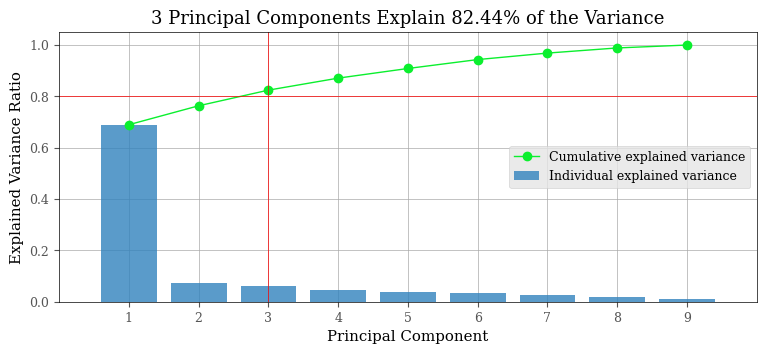

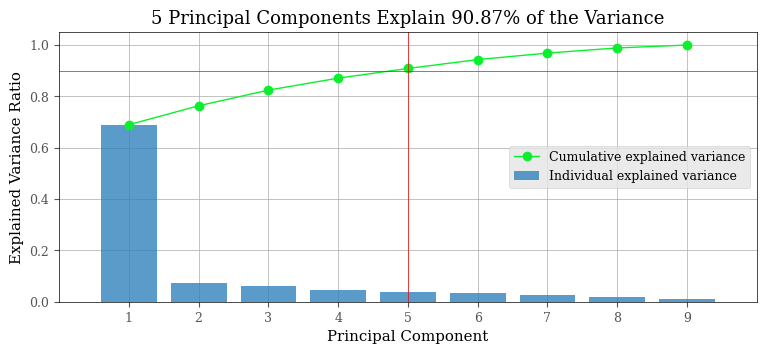

(<Figure size 900x350 with 1 Axes>,
 <Axes: title={'center': '5 Principal Components Explain 90.87% of the Variance'}, xlabel='Principal Component', ylabel='Explained Variance Ratio'>)

In [488]:
pca.plot_explained_variance(threshold_criteria=0.8, figsize=(9,3.5))
pca.plot_explained_variance(threshold_criteria=0.90, figsize=(9,3.5))

# References
----

[1] Taskesen, E. (2020). pca: A Python Package for Principal Component Analysis. [online] GitHub. Available at: https://github.com/erdogant/pca/ [Accessed 29 Dec. 2023].

[2] Garrahan JP, Gillman E, Mair JF. 2023. Machine Learning in Science Part 1 (PHYS4035) Lecture Notes.
‌